In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    ProcessModelDirectives,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    FindResourceOrThrow,
    MultibodyPlant,
    MeshcatVisualizer,
    InverseDynamicsController,
    PassThrough,
    Demultiplexer,
    StateInterpolatorWithDiscreteDerivative,
    MeshcatPoseSliders,
    ConstantVectorSource,
    JointSliders,
    Multiplexer,
    RigidTransform,
    Integrator,
    TrajectorySource,
    PiecewisePose
)
import manipulation
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import ConfigureParser, RenderDiagram

import sys

sys.path.append("../")

from src.station import  MakePandaManipulationStation
from src.diff_ik import TrajectoryPlanner, PandaDiffIKController

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [26]:
# description of robot
robot_directives = """
directives:
    - add_model:
        name: panda_arm
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
    - add_weld:
        parent: world
        child: panda_arm::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda_arm::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
"""

# description of objects in env
env_directives = """
directives:
    - add_model:
        name: floor
        file: package://manipulation/floor.sdf
    - add_weld:
        parent: world
        child: floor::box
        X_PC:
            translation: [0, 0, -0.05]

    # - add_model:
    #     name: foam_brick1
    #     file: package://manipulation/hydro/061_foam_brick.sdf
    # - add_weld:
    #     parent: world
    #     child: foam_brick1::base_link
    #     X_PC:
    #         translation: [0.0004596900773833712, -0.5772629832585529, 0.7451829336930108]

    # - add_model:
    #     name: foam_brick2
    #     file: package://manipulation/hydro/061_foam_brick.sdf
    # - add_weld:
    #     parent: world
    #     child: foam_brick2::base_link
    #     X_PC:
    #         translation: [0.0, -0.5, 0.3]
"""

In [27]:
builder = DiagramBuilder()

# add panda manipulation station
# station is a system consisting of subsytems ie. multi body plant, scene graphs, controllers ... etc
station = MakePandaManipulationStation(
    robot_directives=robot_directives,
    env_directives=env_directives,
    meshcat=meshcat,
    time_step=1e-4
)

builder.AddSystem(station)

plant = station.GetSubsystemByName("plant")
panda_arm = plant.GetModelInstanceByName("panda_arm")
panda_hand = plant.GetModelInstanceByName("panda_hand")

num_panda_arm_positions = plant.num_positions(panda_arm)
num_panda_hand_positions = plant.num_positions(panda_hand)


# get initial pose of end effector
context = plant.CreateDefaultContext()
plant.SetPositions(context, panda_arm, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])

initial_pose = plant.EvalBodyPoseInWorld(context, plant.GetBodyByName("panda_link8"))
goal_pose = RigidTransform(p=[0, -0.5, 0.3], R=initial_pose.rotation())

print("initial_pose: ", initial_pose)

trajectory = PiecewisePose.MakeLinear(
    times=[0, 5.0],
    poses=[initial_pose, goal_pose],
)
traj_V_G = trajectory.MakeDerivative()


diff_ik = builder.AddSystem(PandaDiffIKController(plant=plant))
diff_ik.set_name("PseudoInverseController")

integrator = builder.AddSystem(Integrator(7))
trajectory_source = builder.AddSystem(TrajectorySource(traj_V_G))


builder.Connect(trajectory_source.get_output_port(0), diff_ik.GetInputPort("spatial_velocity"))
builder.Connect(station.GetOutputPort("panda_arm.position_estimated"), diff_ik.GetInputPort("q"))

builder.Connect(diff_ik.get_output_port(0), integrator.get_input_port(0))
builder.Connect(integrator.get_output_port(0), station.GetInputPort("panda_arm.position"))

diagram = builder.Build()
diagram.set_name("PandaFunzo")

context = diagram.CreateDefaultContext()
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context), 
    plant.GetPositions(plant.GetMyContextFromRoot(context), panda_arm)
)


meshcat.StartRecording()
simulator.AdvanceTo(trajectory.end_time())
meshcat.PublishRecording()

initial_pose:  RigidTransform(
  R=RotationMatrix([
    [0.0007607599663954592, -0.9999996829318348, 0.0002353306248870289],
    [-0.9553361862188161, -0.0007963267102639089, -0.2955201129612973],
    [0.2955202066613397, 9.525553773197387e-12, -0.955336489125606],
  ]),
  p=[0.0004596900773833712, -0.5772629832585529, 0.7451829336930108],
)


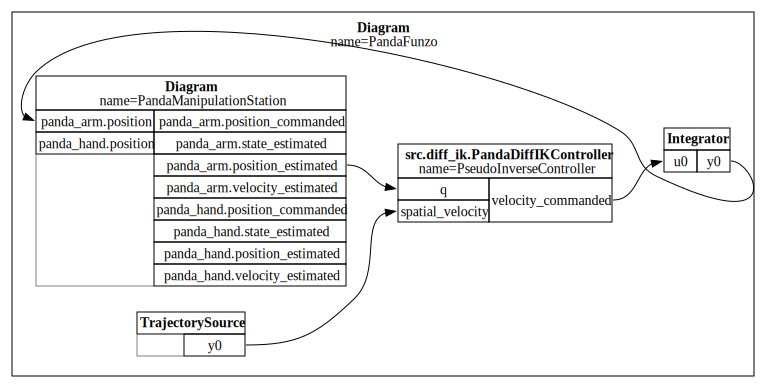

In [24]:
RenderDiagram(diagram, max_depth=1)